In [90]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import cm

import math

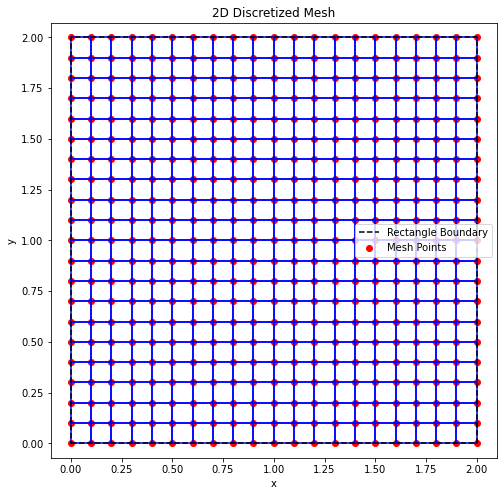

In [91]:
def MakeDiscreteCells(l, w, maxEdgeLength=0.1):
    """
    l, w [float]: dimensions of 2D rectangular body
    
    maxEdgeLength [float]: max length of edge of any cell
    
    returns: array of tuples (2D points) and rectangular cells, indexed into points array.
    """
    assert(l>0)
    assert(w>0)
    
    points2d = []
    cells = []
    
    numRows = math.ceil(l / maxEdgeLength)
    numCols = math.ceil(w / maxEdgeLength)
    lDist = l / numRows
    wDist = w / numCols
    
    rowp2ds = [0]
    colp2ds = [0]
    n = 1
    k = 1
    
    for _ in range(numRows-1):
        rowp2ds.append(n*lDist)
        n += 1
    for _ in range(numCols-1):
        colp2ds.append(k*wDist)
        k += 1
    
    rowp2ds.append(l)
    colp2ds.append(w)
    
    # Generate 2D Points
    for rp in rowp2ds:
        for cp in colp2ds:
            points2d.append((cp, rp))
    
    # Generate Indexed Cells
    for i in range(len(points2d)-(len(colp2ds)+1)):
        if (i>0) and ((i+1)%len(colp2ds)==0):
            continue
    
        cell = [i, i+1, i+len(colp2ds)+1, i+len(colp2ds)]
        cells.append(cell)
    
    return points2d, cells

def VizMesh2D(points2d, cells):
    """
    Given 2D Point and Quad/Rectangle cell information, visualizes the discretized 2D body.
    """
    xCoords, yCoords = zip(*points2d)
    
    # Dynamic aspect ratio
    maxW = max(xCoords) - min(xCoords)
    maxL = max(yCoords) - min(yCoords)
    aspectRatio = maxW / maxL
    base = 8
    width = base * aspectRatio if aspectRatio >= 1 else base
    length = base / aspectRatio if aspectRatio < 1 else base
    
    # Create the plot
    plt.figure(figsize=(width, length))
    plt.scatter(xCoords, yCoords, color='red', label='Mesh Points')  # Scatter plot of points
    
    # Draw the cells
    for cell in cells:
        # Get the corner points of the cell
        cellPoints = [points2d[cell[i]] for i in range(4)] + [points2d[cell[0]]]  # Close the rectangle
        cellX, cellY = zip(*cellPoints)
        plt.plot(cellX, cellY, color='blue')  # Plot cell edges
    
    # Draw the boundary of the rectangle
    rectX = [0, max(xCoords), max(xCoords), 0, 0]
    rectY = [0, 0, max(yCoords), max(yCoords), 0]
    plt.plot(rectX, rectY, color='black', linestyle='--', label='Rectangle Boundary')
    
    # Labels
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('2D Discretized Mesh')
    plt.legend()
    plt.axis('equal')
    plt.show()

# Example
points, cells = MakeDiscreteCells(2, 2, 0.1)
VizMesh2D(points, cells)


In [92]:
materials = {
    "aluminum": 0.1,
    "copper": 0.12,
    "steel": 0.05,
}

def SimulateHeatDiffusion(V, C, heatSourceIndex, temp, material, numSteps=100, snapshotTimes=[10, 50, 100], dt=0.1):
    """
    Simulates heat diffusion on a 2D rectangular mesh.
    
    V [List[Tuple[float, float]]]: List of 2D vertices (points)
    C [List[List[int, int, int, int]]]: List of rectangular cells (indices into V)
    heatSourceIndex [int]: Index of the cell where heat is applied
    temp [float]: Initial temperature of the heat source
    material [str]: String representing material type (maps to thermal diffusivity constant)
    numSteps [int]: Total simulation time steps
    snapshotTimes [List[int]]: List of time steps at which snapshots are taken
    dt [float]: Time step size
    
    Returns:
        snapshots [List[List[float]]]: List of temperature arrays for the specified snapshots
    """
    
    # Thermal diffusivity
    alpha = materials.get(material, 0.1)  # Default if material not found

    # Initialize temperature array
    temperatures = np.zeros(len(V))  # Temperature at each vertex
    snapshots = []

    # Set initial temperature at the heat source
    for vertex_idx in C[heatSourceIndex]:
        temperatures[vertex_idx] = temp

    # Simulate heat transfer
    for step in range(1, numSteps + 1):
        new_temperatures = temperatures.copy()

        for cell in C:
            for vid in cell:
                # Identify neighbors of this vertex
                neighbors = [v for v in cell if v != vid]
                
                # Heat diffusion calculation (simplified)
                new_temperatures[vid] += alpha * dt * sum(
                    temperatures[neighbor] - temperatures[vid] for neighbor in neighbors
                )
        
        temperatures = new_temperatures

        # Store snapshots at specified time steps
        if step in snapshotTimes:
            snapshots.append(temperatures.copy())

    return snapshots

def VizHeatSnapshots(V, C, snapshots, snapshotTimes):
    fig, axes = plt.subplots(1, len(snapshots), figsize=(15, 5))

    for i, (temps, time) in enumerate(zip(snapshots, snapshotTimes)):
        ax = axes[i]
        for cell in C:
            
            # Temperature of the cell
            cellTemp = np.mean([temps[vid] for vid in cell])
            cellPoints = [V[vid] for vid in cell]
            
            # Plot cell w/ corresponding temp color
            polygon = plt.Polygon(cellPoints, closed=True, color=plt.cm.hot(cellTemp / max(temps)))
            ax.add_patch(polygon)

        ax.set_title(f'Time = {time * dt}')
        ax.set_xlim(0, max(v[0] for v in V))
        ax.set_ylim(0, max(v[1] for v in V))
        ax.set_aspect('equal')
    
    # Temperature color gradient
    plt.colorbar(plt.cm.ScalarMappable(cmap='hot'), ax=axes, orientation='horizontal', label='Scaled Temperature')
    plt.show()


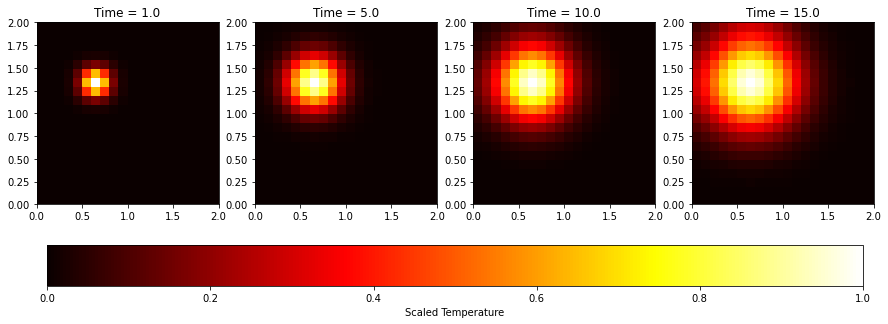

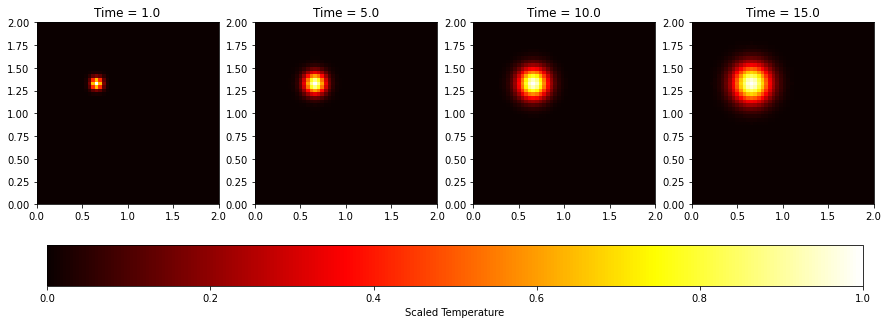

In [93]:
"""
Case 1. 2D, single point heat source. Comparing results with differing mesh refinements.
"""

V1, C1 = MakeDiscreteCells(2, 2, 0.1)
V2, C2 = MakeDiscreteCells(2, 2, 0.04)

snapshots1 = SimulateHeatDiffusion(
    V1, C1, heatSourceIndex=(int(len(C1)/1.5)), temp=270, material="aluminum",
    numSteps=150, snapshotTimes=[10, 50, 100, 150]
)
snapshots2 = SimulateHeatDiffusion(
    V2, C2, heatSourceIndex=(int(len(C2)/1.5)), temp=270, material="aluminum",
    numSteps=150, snapshotTimes=[10, 50, 100, 150]
)

# Visualize snapshots
VizHeatSnapshots(V1, C1, snapshots1, snapshotTimes=[10, 50, 100, 150])
VizHeatSnapshots(V2, C2, snapshots2, snapshotTimes=[10, 50, 100, 150])

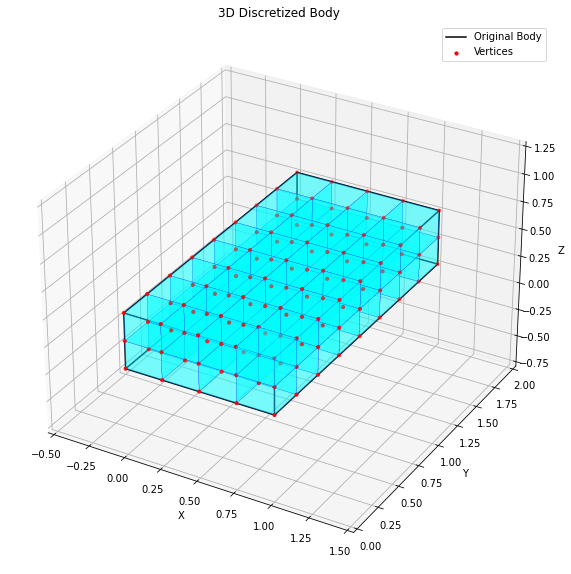

In [98]:
def MakeDiscreteCells3D(l, w, h, maxEdgeLength=0.1):
    """
    l, w, h [float]: Dimensions of the 3D rectangular body
    maxEdgeLength [float]: Maximum edge length of any 3D cuboid cell

    Returns:
    vertices: List of 3D vertices (x, y, z)
    cells: List of cuboid cells (indices into vertices)
    """

    numX = int(np.ceil(l / maxEdgeLength))
    numY = int(np.ceil(w / maxEdgeLength))
    numZ = int(np.ceil(h / maxEdgeLength))

    dx, dy, dz = l / numX, w / numY, h / numZ

    # Generate 3D points
    vertices = [(x * dx, y * dy, z * dz) for x in range(numX + 1)
                                         for y in range(numY + 1)
                                         for z in range(numZ + 1)]

    # Generate cells
    cells = []
    for x in range(numX):
        for y in range(numY):
            for z in range(numZ):
                idx = x * (numY + 1) * (numZ + 1) + y * (numZ + 1) + z
                cell = [
                    idx,
                    idx + 1,
                    idx + (numZ + 1),
                    idx + (numZ + 1) + 1,
                    idx + (numY + 1) * (numZ + 1),
                    idx + (numY + 1) * (numZ + 1) + 1,
                    idx + (numY + 1) * (numZ + 1) + (numZ + 1),
                    idx + (numY + 1) * (numZ + 1) + (numZ + 1) + 1,
                ]
                cells.append(cell)

    return vertices, cells

def viz3DMesh(vertices, cells):
    """
    Visualize a 3D discretized body with its vertices and cells.
    
    Returns: None
    """
    
    x, y, z = zip(*vertices)

    # Create figure
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")

    # Plot vertices
    ax.scatter(x, y, z, color="red", label="Vertices", s=10)

    # Plot cuboid edges
    for cell in cells:
        # Get 8 vertices of the cuboid
        cellPoints = [vertices[idx] for idx in cell]

        # Edges of the cuboid
        edges = [
            [cellPoints[0], cellPoints[1], cellPoints[3], cellPoints[2]],  # Bottom face
            [cellPoints[4], cellPoints[5], cellPoints[7], cellPoints[6]],  # Top face
            [cellPoints[0], cellPoints[1], cellPoints[5], cellPoints[4]],  # Side face
            [cellPoints[2], cellPoints[3], cellPoints[7], cellPoints[6]],  # Side face
            [cellPoints[0], cellPoints[2], cellPoints[6], cellPoints[4]],  # Side face
            [cellPoints[1], cellPoints[3], cellPoints[7], cellPoints[5]],  # Side face
        ]

        # Add cuboid faces to the plot
        poly3d = [[list(point) for point in edge] for edge in edges]
        ax.add_collection3d(Poly3DCollection(poly3d, facecolors='cyan', linewidths=0.1, edgecolors="blue", alpha=0.3))
    
    # Plot edges of the original bounding rectangular prism
    minX, maxX = min(x), max(x)
    minY, maxY = min(y), max(y)
    minZ, maxZ = min(z), max(z)

    # Define the 8 vertices of the bounding box
    boundingVertices = [
        (minX, minY, minZ), (maxX, minY, minZ), (maxX, maxY, minZ), (minX, maxY, minZ),  # Bottom face
        (minX, minY, maxZ), (maxX, minY, maxZ), (maxX, maxY, maxZ), (minX, maxY, maxZ)   # Top face
    ]

    # Define edges connecting the bounding vertices
    boundingEdges = [
        [boundingVertices[0], boundingVertices[1]], [boundingVertices[1], boundingVertices[2]], 
        [boundingVertices[2], boundingVertices[3]], [boundingVertices[3], boundingVertices[0]],  # Bottom face
        [boundingVertices[4], boundingVertices[5]], [boundingVertices[5], boundingVertices[6]], 
        [boundingVertices[6], boundingVertices[7]], [boundingVertices[7], boundingVertices[4]],  # Top face
        [boundingVertices[0], boundingVertices[4]], [boundingVertices[1], boundingVertices[5]], 
        [boundingVertices[2], boundingVertices[6]], [boundingVertices[3], boundingVertices[7]]   # Vertical edges
    ]

    # Add the edges to the plot
    for edge in boundingEdges:
        edgeX, edgeY, edgeZ = zip(*edge)
        ax.plot(edgeX, edgeY, edgeZ, color="black", label="Original Body" if "Original Body" not in ax.get_legend_handles_labels()[1] else None)
    
    # Set labels and legend
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("3D Discretized Body")
    ax.legend()

    # Equal aspect ratio for better visualization
    max_range = max(max(x) - min(x), max(y) - min(y), max(z) - min(z)) / 2.0
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    plt.show()
    return

# Generate 3D body
V, C = makeDiscreteCells3D(1, 2, 0.5, 0.25)

# Visualize
viz3DMesh(V, C)


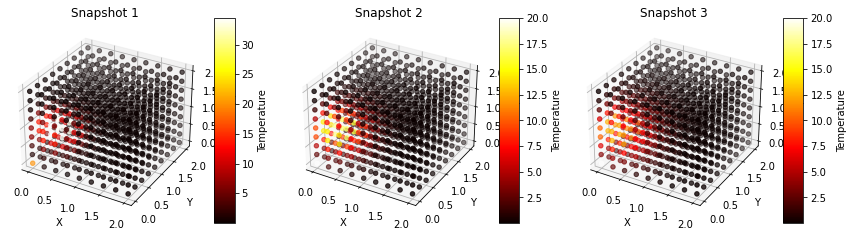

In [89]:
def SimulateHeatDiffusion3D(vertices, cells, heatSourceIdx, heatSourceTemp, material, boundaryConditions, numSteps=100, dt=0.1):
    """
    Simulates heat diffusion on a 3D body.
    
    Parameters:
    - vertices: List of 3D points.
    - cells: List of cells, each a list of point indices.
    - heatSourceIdx: Index of the cell to be used as the heat source.
    - heatSourceTemp: Initial temperature at the heat source.
    - material: Name of the material (used to fetch thermal diffusivity).
    - boundaryConditions: List of dictionaries specifying boundary conditions.
    - numSteps: Number of time steps for simulation.
    - dt: Time step size.
    
    Returns:
    - snapshots: List of temperature distributions at selected timesteps.
    """

    # Thermal diffusivity for the material
    materials = {
        "copper": 0.01,
        "aluminum": 0.02,
        "steel": 0.005
    }
    alpha = materials.get(material, 0.01)  # Default alpha
    temperatures = np.zeros(len(vertices))
    snapshots = []

    for vertexIdx in cells[heatSourceIdx]:
        temperatures[vertexIdx] = heatSourceTemp

    for step in range(1, numSteps + 1):
        newTemperatures = temperatures.copy()

        for cell in cells:
            for vertexIdx in cell:
                neighbors = [v for v in cell if v != vertexIdx]
                newTemperatures[vertexIdx] += alpha * dt * sum(
                    temperatures[n] - temperatures[vertexIdx] for n in neighbors
                )

        # Apply boundary conditions
        for bc in boundaryConditions:
            newTemperatures[bc["indices"]] = bc["value"]

        temperatures = newTemperatures

        if step % (numSteps // 3) == 0:
            snapshots.append(temperatures.copy())

    return snapshots

def vizHeatDiffusion3D(vertices, snapshots):
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(12, 6))

    for i, temps in enumerate(snapshots):
        ax = fig.add_subplot(1, len(snapshots), i + 1, projection="3d")
        x, y, z = zip(*vertices)
        scatter = ax.scatter(x, y, z, c=temps, cmap="hot", marker="o")
        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=10, label="Temperature")
        ax.set_title(f"Snapshot {i + 1}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")

    plt.tight_layout()
    plt.show()


# Define boundary conditions
boundaryConditions = [{"indices": [0], "value": 20}]  # Example for fixed temperature

# Simulate heat diffusion
snapshots = simulateHeatDiffusion3D(
    V, C, heatSourceIdx=75, heatSourceTemp=100, material="copper", boundaryConditions=boundaryConditions
)
# Visualize
vizHeatDiffusion3D(V, snapshots)